Generating multivariate T-student random samples
------------------------------------------------------------

Let's generate $N$ samples from a multivariate, $p$-dimensional T-student distribution with $p = 3$. First, define the parameters that define the distribution ($\vec{\mu}$, $\Sigma$ and $\nu$):

In [3]:
import numpy as np

# Mean vector:
mu = np.array([0.,20.,40.])
# Sigma matrix:
Sigma = np.array([[237., -76.,  -5.],
                  [-76.,  29., -11.],
                  [-5., -11.,  43.]])
# Degrees of freedom:
nu = 5

The scale mixture representation of a T-student random vector $\vec{X}$ is given by:

$\vec{X} = \vec{\mu} + \frac{\vec{Y}}{\sqrt{V/\nu}}$,

where $\vec{Y}$ is a random-normal vector with mean $\vec{0}$ and covariance matrix $\Sigma$, $V$ is a chi-square random variable with $\nu$ degrees of freedom. Let's generate $N=1000$ samples from a T-student distribution. To this end, first create $N$ random samples from the 3-dimensional $\vec{Y}$ vector:


In [4]:
N = 1000
Y = np.random.multivariate_normal(np.zeros(3),Sigma,N)
print(Y.shape)

(1000, 3)


Note the `Y` array above has 1000 rows and 3 columns, i.e., each row is one sample from the random vector $\vec{Y}$. Now following the scale mixture representation for the T-student, we have to divide each row by random samples from the random variable $\sqrt{V/\nu}$, and add the mean vector to that result:

In [5]:
# Sample chi-square random variables with nu degrees of freedom:
X = np.zeros(Y.shape)
V = np.random.chisquare(nu,N)
for i in range(N):
    X[i,:] = mu + Y[i,:]/np.sqrt(V[i]/nu)
# Note that an easier way of getting the X vector is doing X = mu + Y/(np.sqrt(V/nu))[:,None]
# The for loop above was just for pedagogical purposes

Let's compare our T-student random variates stored on the `X` variables with random samples from a multivariate normal distribution with mean $\vec{\mu}$ and covariance $\Sigma$:

In [6]:
Xnormal = np.random.multivariate_normal(mu,Sigma,N)

In [9]:
# Generate corner plots:
import matplotlib.pyplot as plt
import corner
names = ['$x_1$','$x_2$','$x_3$']
print(Xnormal.shape,X.shape)
# Corner plot for multivariate normal samples:
figure = corner.corner(Xnormal, labels = names, color='cornflowerblue')
# Corner plot for t-student samples. Weight the samples differently so the marginals have similar scales:
corner.corner(X,fig=figure, color='orangered')
plt.show()

(1000, 3) (1000, 3)


<Figure size 760x760 with 9 Axes>

Orange samples come from a multivariate t-student; blue ones from a multivariate normal. Note how the wings differ between the samples. 

A quick function to generate random samples from a T-student thus would look like:

In [10]:
def multivariatet_samples(mu, Sigma, nu, N):
    p = len(mu)
    Y = np.random.multivariate_normal(np.zeros(p),Sigma,N)
    V = np.random.chisquare(nu,N)
    return mu + Y/(np.sqrt(V/nu))[:,None]

Indeed, comparing this function with the multivariate-T samples above gives:

(1000, 3) (1000, 3)


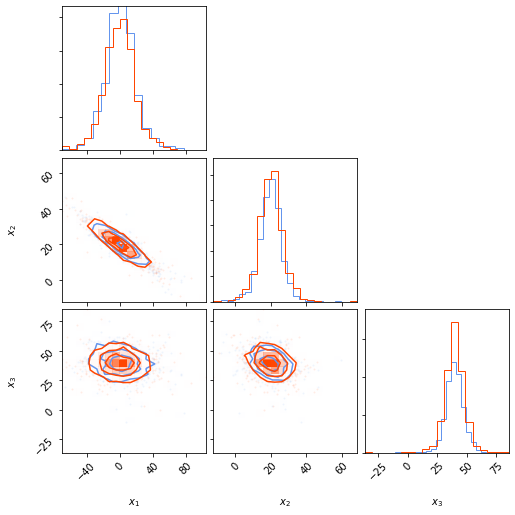

In [21]:
X2 = multivariatet_samples(mu, Sigma, nu, N)
names = ['$x_1$','$x_2$','$x_3$']
print(Xnormal.shape,X.shape)
# Corner plot for multivariate normal samples:
figure = corner.corner(X2, labels = names, color='cornflowerblue')
# Corner plot for t-student samples. Weight the samples differently so the marginals have similar scales:
corner.corner(X,fig=figure, color='orangered')
plt.show()

Estimating parameters from a multivariate-t student distribution
-------

If the $\nu$ parameter is known, then estimaeting the parameters of a multivariate-t student distribution is "easy" through the Expectation-Minimization (EM) algorithm. The classic algorithm for the Multivariate-t in this case is the one outlined in [Nadarajah and Kotz (2007; Section 3)](http://www-users.math.umn.edu/~bemis/MFM/workshop/2010/estimating_multivariate_t.pdf). The idea is that to estimate the parameters of a $p$-variated multivariate t-student you:

1. Start with guess estimates $\hat{\vec{\mu}}^{(m)}$ and $\hat{\Sigma}^{(m)}$ for $m=0$.
2. Compute $w_i^{(m)} = (\nu + p)/\left[\nu + (\vec{x}_i - \vec{\mu}^{(m)})^T (\Sigma^{(m)})^{-1}(\vec{x}_i - \vec{\mu}^{(m)})\right]$
3. Compute the next estimates $\hat{\vec{\mu}}^{(m+1)}$ and $\hat{\Sigma}^{(m+1)}$ with $\hat{\vec{\mu}}^{(m+1)} = \sum w_i^{(m)} \vec{x}_i/\sum w_i^{(m)} $ and $\hat{\Sigma}^{(m+1)} = \frac{1}{N} \sum w_i^{(m)} (\vec{x}_i - \hat{\vec{\mu}}^{(m+1)})(\vec{x}_i - \hat{\vec{\mu}}^{(m+1)})^T$
4. Repeat 2. and 3. until a desired convergence criterion is met.

Here, the $\vec{x}_i$ are p-varied vectors, $i=1,...,N$ in our notation --- $N$ being the number of samples. A function that does this is below:


In [31]:
def estimate_t_parameters(X, nu, mu_guess, Sigma_guess, eps_mu, eps_Sigma):
    """""
    Given samples from a p-variate t-student (X --- X.shape is N,p), an initial guess for the mu 
    vector mu_guess and Sigma matrix Sigma_guess, run the above EM algorithm until the absolute 
    difference between the next estimated mu is eps_mu and the difference between the next estimated 
    sigma is eps_Sigma
    """""
    N = X.shape[0]
    w = np.zeros(N)
    p = X.shape[1]
    previous_mu, previous_Sigma = mu_guess,Sigma_guess
    mu = mu_guess
    Sigma = Sigma_guess
    while True:
        # Compute weights:
        for i in range(N):
            xi = X[i,:]
            matrix_mult = ((np.matrix(xi - mu)*np.matrix(np.linalg.inv(Sigma)))*np.matrix(xi - mu).transpose())
            w[i] = (nu + p)/(nu + np.array(matrix_mult)[0][0])
        # Generate next value of mu:
        sw = np.sum(w)
        mu = np.sum(X*(w/sw)[:,None],axis=0)
        # Generate next value of Sigma:
        Sigma = 0.
        for i in range(N):
            xi = X[i,:]
            Sigma = Sigma + w[i]*np.array(np.matrix(xi - mu).transpose() * np.matrix(xi - mu))
        Sigma = Sigma/N
        mu_dist = np.sqrt(np.sum((mu-previous_mu)**2))
        Sigma_dist = np.sqrt(np.sum((Sigma-previous_Sigma)**2))
        if mu_dist < eps_mu and Sigma_dist < eps_Sigma:
            break
        else:
            previous_mu, previous_Sigma = mu, Sigma
    return mu,Sigma

Let's run this EM algorithm by giving as initial guesses the "gaussian" mean and covariance matrix estimates of our samples:

In [32]:
mu_guess, Sigma_guess = np.mean(X,axis=0), np.cov(X.T)
print('Initial guesses:',mu_guess,Sigma_guess)
mu_out, Sigma_out = estimate_t_parameters(X, nu, mu_guess, Sigma_guess, 0.1, 0.1)
print('Final outputs:',mu_out, Sigma_out)

Initial guesses: [ 0.06185536 20.05372087 39.64418638] [[ 391.92777691 -125.18842807   -8.75476085]
 [-125.18842807   48.2524884   -19.38084653]
 [  -8.75476085  -19.38084653   72.94104893]]
Final outputs: [-0.17302285 20.08816977 39.855427  ] [[244.8475149  -78.02777863  -5.74530965]
 [-78.02777863  29.51450725 -10.68127995]
 [ -5.74530965 -10.68127995  42.19018425]]


The results are in pretty good agreement!